In [13]:
import pickle
import gzip
import os
import sys

import sentencepiece as spm

from representjs import RUN_DIR, CSNJS_DIR
from data.precomputed_dataset import PrecomputedDataset

In [14]:
import torch

In [16]:
import numpy as np
import textdistance

In [17]:
import matplotlib.pyplot as plt

In [18]:
DEFAULT_CSNJS_TRAIN_FILEPATH = str(CSNJS_DIR / "javascript_dedupe_definitions_nonoverlap_v2_train.jsonl.gz")
DEFAULT_SPM_UNIGRAM_FILEPATH = str(CSNJS_DIR / "csnjs_8k_9995p_unigram_url.model")

AUGMENTED_DATASET_PATH = "/data/ajay/coderep/representjs/data/codesearchnet_javascript/javascript_augmented.pickle.gz"

In [20]:
config = dict(
    train_filepath=AUGMENTED_DATASET_PATH,
    program_mode="contrastive",
    limit_dataset_size=-1,
    subword_regularization_alpha=0.1,
    # MIN ALTERNATIVES = 2, SWREG=0.1 used for BiLSTM
    # MIN ALT=1, SWREG=0.1 for contrastive Transformer  TODO: try this.
    # MIN ALT=1, SWREG=0. for hybrid MLM, contrastive Transformer
    min_alternatives=2,
    max_length=1024,
    spm_filepath=DEFAULT_SPM_UNIGRAM_FILEPATH
)

sp = spm.SentencePieceProcessor()
sp.Load(config["spm_filepath"])
pad_id = sp.PieceToId("[PAD]")
mask_id = sp.PieceToId("[MASK]")

train_dataset = PrecomputedDataset(
    config["train_filepath"],
    min_alternatives=config["min_alternatives"],
    program_mode=config["program_mode"],
    limit_size=config["limit_dataset_size"],
    sp=sp,
    subword_regularization_alpha=config["subword_regularization_alpha"],
    max_length=config["max_length"],
)

2020-11-14 01:54:04.871 | DEBUG    | data.precomputed_dataset:__init__:37 - Loading /data/ajay/coderep/representjs/data/codesearchnet_javascript/javascript_augmented.pickle.gz
2020-11-14 01:56:14.477 | DEBUG    | data.precomputed_dataset:__init__:45 - Loaded 1843099 examples in 129.605s
2020-11-14 01:56:24.691 | DEBUG    | data.precomputed_dataset:__init__:50 - Converted examples to lists of alternatives
2020-11-14 01:56:25.034 | DEBUG    | data.precomputed_dataset:__init__:53 - Filtered dataset to 1644353 examples with at least 2 alternatives


# Define edit distance dataset

In [71]:
class EDDataset(torch.utils.data.Dataset):
    def __init__(self, precomputed_dataset, limit_size=-1):
        super().__init__()
        self.precomputed_dataset = precomputed_dataset
        self.limit_size = limit_size

    def __len__(self):
        if self.limit_size > 0:
            return min(self.limit_size, len(self.precomputed_dataset))
        return len(self.precomputed_dataset)

    def __getitem__(self, idx):
        a, b = self.precomputed_dataset[idx]
        a = list(a.numpy())
        b = list(b.numpy())
        distance = textdistance.levenshtein.distance(a, b)

        maxlen = max(len(a), len(b))
        ratio = (maxlen - distance) / float(maxlen)  # similarity ratio
        return ratio

In [72]:
eddataset = EDDataset(train_dataset)

# Define parallel dataloader

In [80]:
dl = torch.utils.data.DataLoader(eddataset, batch_size=32, shuffle=False, num_workers=64, drop_last=False)

In [83]:
all_ratios = np.zeros(len(eddataset), dtype=np.float)

In [ ]:
print("text distance, similarities")

i = 0
for batch in dl:
    batch = batch.numpy()
    all_ratios[i:i+len(batch)] = batch
    i += len(batch)
    if i % (32 * 10) == 0:
        average_ratio = np.mean(all_ratios[:i])
        sdev = np.std(all_ratios[:i])
        serr = sdev / np.sqrt(i)
        print(f"Processed {i} pairs of programs ({i / len(all_ratios) * 100} %). Average ratio: {average_ratio} += {serr}")

average_ratio = np.mean(all_ratios[:i])
sdev = np.std(all_ratios[:i])
serr = sdev / np.sqrt(i)
print(f"Processed {i} pairs of programs. Average ratio: {average_ratio} += {serr}")

text distance, similarities
Processed 320 pairs of programs (0.01946054162336189 %). Average ratio: 0.3162925668898958 += 0.005729668634869503
Processed 640 pairs of programs (0.03892108324672378 %). Average ratio: 0.3289400737521276 += 0.004047431244050049
Processed 960 pairs of programs (0.05838162487008568 %). Average ratio: 0.32592086926750574 += 0.003194651072201106
Processed 1280 pairs of programs (0.07784216649344756 %). Average ratio: 0.3283771853342653 += 0.0028183710123059957
Processed 1600 pairs of programs (0.09730270811680947 %). Average ratio: 0.32819730119914103 += 0.0025136647565337325
Processed 1920 pairs of programs (0.11676324974017135 %). Average ratio: 0.32767478017979657 += 0.002260463952219395
Processed 2240 pairs of programs (0.13622379136353327 %). Average ratio: 0.32753357682536194 += 0.002072603762363024
Processed 2560 pairs of programs (0.15568433298689513 %). Average ratio: 0.33590366400497346 += 0.0020475848607816147
Processed 2880 pairs of programs (0.175

In [86]:
average_ratio = np.mean(all_ratios[:i])
sdev = np.std(all_ratios[:i])
serr = sdev / np.sqrt(i)
print(f"Processed {i} pairs of programs. Average ratio: {average_ratio} += {serr}")

Processed 1644353 pairs of programs. Average ratio: 0.3452640314630394 += 8.669583973361393e-05


In [89]:
np.save("positives_all_ratios.npy", all_ratios)

# Plot histograms

In [288]:
neg_ratios = np.load("negatives_all_ratios_1641600.npy")
neg_ratios = np.random.choice(neg_ratios, len(all_ratios), replace=False)

In [296]:
len(all_ratios)

1644353

In [297]:
len(neg_ratios)

1644353

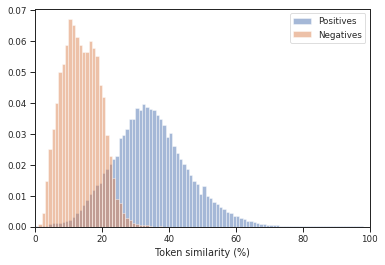

In [289]:
plt.plot()
bins = np.arange(101)
plt.hist(all_ratios * 100, bins=bins, alpha=0.5, density=True, label="Positives", cumulative=False)
plt.hist(neg_ratios * 100, bins=bins, alpha=0.5, density=True, label="Negatives", cumulative=False)
plt.xlim([0, 100])
plt.legend()
plt.xlabel("Token similarity (%)")
# plt.show()
plt.savefig("token_similarity.pdf")

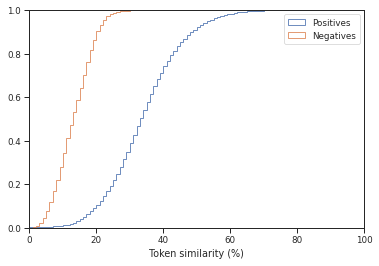

In [290]:
bins = np.arange(101)
plt.hist(all_ratios * 100, bins=bins, histtype="step", density=True, label="Positives", cumulative=True)
plt.hist(neg_ratios * 100, bins=bins, histtype="step", density=True, label="Negatives", cumulative=True)
plt.xlim([0, 100])
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Token similarity (%)")
plt.show()

In [298]:
print("Mean similarity, positives:", np.mean(all_ratios))
print("Mean similarity, negatives:", np.mean(neg_ratios))
print("Median similarity, positives:", np.median(all_ratios))
print("Median similarity, negatives:", np.median(neg_ratios))

Mean similarity, positives: 0.3452640314630394
Mean similarity, negatives: 0.13737635457650332
Median similarity, positives: 0.3389830508474576
Median similarity, negatives: 0.134765625


In [292]:
import seaborn as sns
sns.set("paper")
sns.set_style("ticks")

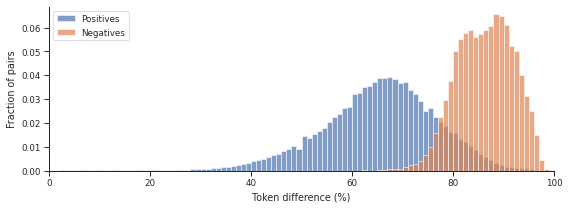

In [293]:
plt.figure(figsize=(8, 3))
bins = np.arange(101)
plt.hist(100 - all_ratios * 100, bins=bins, alpha=0.7, density=True, label="Positives", cumulative=False)
plt.hist(100 - neg_ratios * 100, bins=bins, alpha=0.7, density=True, label="Negatives", cumulative=False)
plt.xlim([0, 100])
plt.legend()
plt.xlabel("Token difference (%)")
plt.ylabel("Fraction of pairs")
sns.despine()
plt.tight_layout()
plt.savefig("token_difference_sns.pdf")

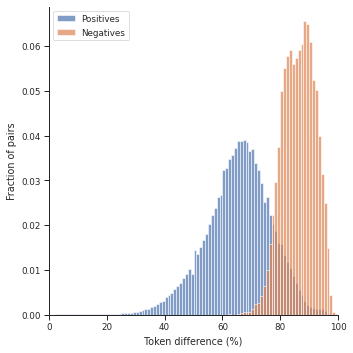

In [294]:
plt.figure(figsize=(5, 5))
bins = np.arange(101)
plt.hist(100 - all_ratios * 100, bins=bins, alpha=0.7, density=True, label="Positives", cumulative=False)
plt.hist(100 - neg_ratios * 100, bins=bins, alpha=0.7, density=True, label="Negatives", cumulative=False)
plt.xlim([0, 100])
plt.legend()
plt.xlabel("Token difference (%)")
plt.ylabel("Fraction of pairs")
sns.despine()
plt.tight_layout()
plt.savefig("token_difference_sns_squeeze.pdf")

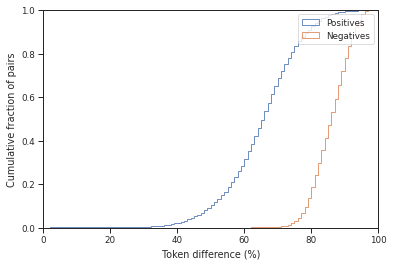

In [295]:
bins = np.arange(101)
plt.hist(100 - all_ratios * 100, bins=bins, histtype="step", density=True, label="Positives", cumulative=True)
plt.hist(100 - neg_ratios * 100, bins=bins, histtype="step", density=True, label="Negatives", cumulative=True)
plt.xlim([0, 100])
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Token difference (%)")
plt.ylabel("Cumulative fraction of pairs")
plt.savefig("token_difference_cdf_sns.pdf")

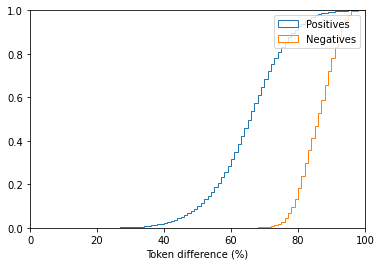

In [227]:
bins = np.arange(101)
plt.hist(100 - all_ratios * 100, bins=bins, histtype="step", density=True, label="Positives", cumulative=True)
plt.hist(100 - neg_ratios * 100, bins=bins, histtype="step", density=True, label="Negatives", cumulative=True)
plt.xlim([0, 100])
plt.ylim([0, 1])
plt.legend()
plt.xlabel("Token difference (%)")
plt.ylabel("Cumulative fraction of pairs")
plt.show()

In [299]:
print("Mean difference, positives:", 1 - np.mean(all_ratios))
print("Mean difference, negatives:", 1 - np.mean(neg_ratios))
print("Median difference, positives:", 1 - np.median(all_ratios))
print("Median difference, negatives:", 1 - np.median(neg_ratios))
print("75% difference, positives:", np.quantile(1 - all_ratios, 0.75))
print("75% difference, negatives:", np.quantile(1 - neg_ratios, 0.75))
print("25% difference, positives:", np.quantile(1 - all_ratios, 0.25))
print("25% difference, negatives:", np.quantile(1 - neg_ratios, 0.25))

Mean difference, positives: 0.6547359685369606
Mean difference, negatives: 0.8626236454234967
Median difference, positives: 0.6610169491525424
Median difference, negatives: 0.865234375
75% difference, positives: 0.7291666666666667
75% difference, negatives: 0.9046762589928058
25% difference, positives: 0.5869565217391304
25% difference, negatives: 0.8217821782178218


/home/ajay/miniconda3/envs/representjs/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


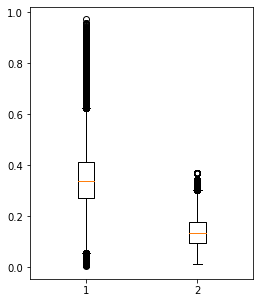

In [229]:
plt.figure(figsize=(4, 5))
plt.boxplot([all_ratios, neg_ratios])
plt.show()

In [230]:
np.quantile(all_ratios, 0.75)

0.41304347826086957

In [231]:
np.quantile(all_ratios, 0.05)

0.17094017094017094

In [232]:
np.quantile(neg_ratios, 0.95)

0.22727272727272727

In [233]:
np.quantile(neg_ratios, 0.25)

0.09534883720930233

# ROC plot of thresholds on ED ratio

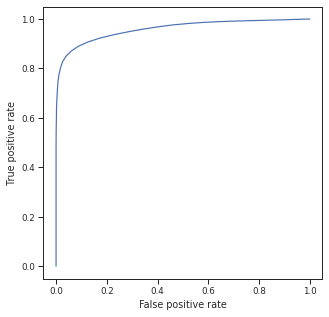

In [302]:
thresholds = np.linspace(0, 1, 100)
tpr = []
fpr = []
accs = []
for th in thresholds:
    fn = np.sum(all_ratios <= th) / len(all_ratios)
    tn = np.sum(neg_ratios <= th) / len(neg_ratios)
    fp = np.sum(neg_ratios > th) / len(neg_ratios)
    tp = np.sum(all_ratios > th) / len(all_ratios)
    tpr.append(tp)
    fpr.append(fp)

#     acc = (np.sum(all_ratios > th) + np.sum(neg_ratios < th)) / (len(all_ratios) + len(neg_ratios))
    acc = (np.sqrt(np.sum(all_ratios > th)) + np.sum(neg_ratios < th)) / (np.sqrt(len(all_ratios)) + len(neg_ratios))
    accs.append(acc)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

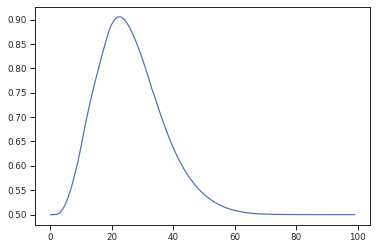

In [301]:
plt.plot(accs)

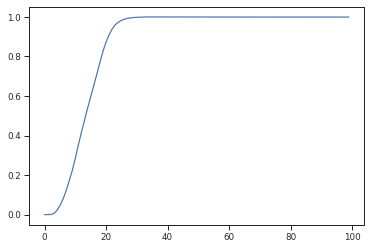

In [303]:
plt.plot(accs)

# Ascii histogram

In [191]:
!pip3 install ascii_graph

  Created wheel for ascii-graph: filename=ascii_graph-1.5.1-py3-none-any.whl size=11875 sha256=ad4ee08c6cf74dd25826773dd7a27c5adfefbbc3c8b7c55fef64a9a3dcf50dc7
  Stored in directory: /home/ajay/.cache/pip/wheels/b1/9a/33/42423a3df123c8d702661601fb0b9e91c68332727dd6dc2125
Successfully built ascii-graph


In [192]:
from ascii_graph import Pyasciigraph

test = [('long_label', 423), ('sl', 1234), ('line3', 531),
    ('line4', 200), ('line5', 834)]

graph = Pyasciigraph()
for line in  graph.graph('test print', test):
    print(line)

test print
###############################################################################
████████████████████                                            423  long_label
█████████████████████████████████████████████████████████████  1234  sl        
██████████████████████████                                      531  line3     
█████████                                                       200  line4     
█████████████████████████████████████████                       834  line5     


In [197]:
!pip3 install -e https://github.com/Kobold/text_histogram.git

ERROR: https://github.com/Kobold/text_histogram.git is not a valid editable requirement. It should either be a path to a local project or a VCS URL (beginning with svn+, git+, hg+, or bzr+).


In [304]:
import importlib
import text_histogram
importlib.reload(text_histogram)

<module 'text_histogram' from '/home/ajay/coderep/representjs/representjs/text_histogram.py'>

In [307]:
text_histogram.histogram(100 * (1 - all_ratios), buckets=10, minimum=0., maximum=100.)

# NumSamples = 1644353; Min = 0.00; Max = 100.00
# Mean = 65.473597; Variance = 123.592344; SD = 11.117209; Median 66.101695
# each ∎ represents a count of 7958
   0 -   10 [00%]: 
  10 -   20 [00%]: 
  20 -   30 [00%]: 
  30 -   40 [01%]: ∎∎∎
  40 -   50 [07%]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎
  50 -   60 [19%]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎
  60 -   70 [36%]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎
  70 -   80 [26%]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎
  80 -   90 [08%]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎
  90 -  100 [00%]: ∎


In [308]:
text_histogram.histogram(100 * (1 - neg_ratios), buckets=10, minimum=0., maximum=100.)

# NumSamples = 1644353; Min = 0.00; Max = 100.00
# Mean = 86.262365; Variance = 29.974485; SD = 5.474896; Median 86.523438
# each ∎ represents a count of 12798
   0 -   10 [00%]: 
  10 -   20 [00%]: 
  20 -   30 [00%]: 
  30 -   40 [00%]: 
  40 -   50 [00%]: 
  50 -   60 [00%]: 
  60 -   70 [00%]: 
  70 -   80 [13%]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎
  80 -   90 [58%]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎
  90 -  100 [27%]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎


In [208]:
text_histogram.histogram?

Signature:
text_histogram.histogram(
    stream,
    minimum=None,
    maximum=None,
    buckets=None,
    custbuckets=None,
    calc_msvd=True,
)
Docstring:
Loop over the stream and add each entry to the dataset, printing out at the end


minimum: minimum value for graph
maximum: maximum value for graph
buckets: Number of buckets to use for the histogram
custbuckets: Comma seperated list of bucket edges for the histogram
calc_msvd: Calculate and display Mean, Variance and SD.
File:      ~/coderep/representjs/representjs/text_histogram.py
Type:      function


In [210]:
text_histogram.histogram(neg_ratios, buckets=10)

# NumSamples = 335360; Min = 0.01; Max = 0.33
# Mean = 0.137572; Variance = 0.002969; SD = 0.054486; Median 0.134904
# each ∎ represents a count of 924
    0.0127 -     0.0448 [ 11146]: ∎∎∎∎∎∎∎∎∎∎∎∎
    0.0448 -     0.0768 [ 36771]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎
    0.0768 -     0.1089 [ 63286]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎
    0.1089 -     0.1410 [ 69370]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎
    0.1410 -     0.1730 [ 62669]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎
    0.1730 -     0.2051 [ 51936]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎
    0.2051 -     0.2371 [ 29229]: ∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎∎
    0.2371 -     0.2692 [  7369]: ∎∎∎∎∎∎∎
    0.2692 -     0.3013 [  2624]: ∎∎
    0.3013 -     0.3333 [   768]: 
